In [102]:
import argparse
import pandas as pd
import numpy as np
import time
import calendar
import os

import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates

In [269]:
def generate_breaker_data(name, month, year):
    # calculate number of days in the given month and year a create a date range
    num_days = pd.Period(f'{year}-{month}').days_in_month
    date_rng = pd.date_range(start=f'{year}-{month}-01 00:00:00', end=f'{year}-{month}-{num_days} 23:59:00', freq='5min')

    # set random seed for randomization
    np.random.seed(int(time.time()))

    # generate random voltage values with mean of 380 kV and standard deviation of 2.0%
    voltage_mean = 380
    voltage_std_dev = voltage_mean * 0.020
    voltage_values = np.random.normal(loc=voltage_mean, scale=voltage_std_dev, size=len(date_rng))

    # generate random current values with mean of 2250 Amperes and standard deviation of 2.5%
    current_mean = 2250
    current_std_dev = current_mean * 0.025
    current_values = np.random.normal(loc=current_mean, scale=current_std_dev, size=len(date_rng))

    # generate random temperature values with mean of 70 degrees farenheit and standard deviation of 2.5%
    temp_mean = 70.0
    temp_std_dev = temp_mean * 0.025
    temp_values = np.random.normal(loc=temp_mean, scale=temp_std_dev, size=len(date_rng))

    # generate random moisture values with mean of 10 ppm and standard deviation of 20.0%
    moisture_mean = 10
    moisture_std_dev = moisture_mean * 0.200
    moisture_values = np.random.normal(loc=moisture_mean, scale=moisture_std_dev, size=len(date_rng))

    # generate random density values with mean of 6.75 lb/ft3 and standard deviation of 2.0%
    density_mean = 6.75
    density_std_dev = density_mean * 0.0001
    density_values = np.random.normal(loc=density_mean, scale=density_std_dev, size=len(date_rng))

    # generate random moisture values with mean of 10ppm and standard deviation of 2.0%
    pressure_mean = 80
    pressure_std_dev = pressure_mean * 0.020
    pressure_values = np.random.normal(loc=pressure_mean, scale=pressure_std_dev, size=len(date_rng))

    # apply correlations
    voltage_values += voltage_values * np.random.normal(loc=0, scale=0.05, size=len(date_rng)) * -(current_values/current_mean - 1)
    current_values += current_values * np.random.normal(loc=0, scale=0.05, size=len(date_rng)) * (voltage_values/voltage_mean - 1)
    temp_values += temp_values * np.random.normal(loc=0, scale=0.05, size=len(date_rng)) * (current_values/current_mean - 1)
    density_values += density_values * np.random.normal(loc=0, scale=0.05, size=len(date_rng)) * -(moisture_values/moisture_mean - 1)
    pressure_values += pressure_values * np.random.normal(loc=0, scale=0.05, size=len(date_rng)) * -(moisture_values/moisture_mean - 1)

    # round values
    voltage_values = np.round(voltage_values, 1)
    current_values = np.round(current_values, 0)
    temp_values = np.round(temp_values, 1)
    moisture_values = np.round(moisture_values, 0)
    density_values = np.round(density_values, 2)
    pressure_values = np.round(pressure_values, 1)

    # create DataFrame with timestamp, name, current and voltage columns
    data = pd.DataFrame({
        'timestamp': date_rng,
        'name': name,
        'voltage (kV)': voltage_values,
        'current (A)': current_values,
        'temperature (F)': temp_values,
        'moisture (ppm)': moisture_values,
        'density (lb/ft3)': density_values,
        'pressure (psi)': pressure_values
    })

    return data

In [270]:
#Create Circuit Breaker Overload in Voltage and Current
def get_voltage_failure(df, failure_date, failure_period=3, vstep=.15, cstep=1):
    # get a slice of the data from 3 days prior to the failure date
    df_fail = df[(df['timestamp'] <= failure_date) & (df['timestamp'] > failure_date - timedelta(days=failure_period))]

    #add a gradual increase to voltage and current during this period
    df_fail['voltage (kV)'] += np.arange(0, len(df_fail)*vstep, vstep)
    df_fail['current (A)'] += np.arange(0, len(df_fail)*cstep, cstep)

    #replace the slice into overall data
    df[(df['timestamp'] <= failure_date) & (df['timestamp'] > failure_date - timedelta(days=failure_period))] = df_fail

    #zero out voltage and current after
    df.loc[(df['timestamp'] > failure_date), ['voltage (kV)', 'current (A)']] = 0
    
    return df

In [281]:
#Create Circuit Breaker SF6 Leak
def get_gas_failure(df, failure_date, failure_period=.5, pstep=.02, dstep=.01, mstep=.2):
    # get a slice of the data from 3 days prior to the failure date
    df_fail = df[df['timestamp'] > failure_date - timedelta(days=failure_period)]

    #add a gradual decrease to density during this period
    df_fail['density (lb/ft3)'] -= np.arange(0, len(df_fail)*dstep, dstep)
    #df_fail['pressure (psi)'] -= np.arange(0, len(df_fail)*pstep, pstep)
    #df_fail['moisture (ppm)'] += np.arange(0, len(df_fail)*mstep, mstep)

    #replace the slice into overall data
    df[df['timestamp'] > failure_date - timedelta(days=failure_period)] = df_fail

    return df

# Start of code

In [282]:
#Create normal data
name = 'BKR-0030107'
month = 4
year = 2019
df_raw = generate_breaker_data(name, month, year)

failure_date = pd.to_datetime('2019-04-10T00:05:00')
df_volt = get_voltage_failure(df_raw, failure_date)
df_gas = get_gas_failure(df_raw, failure_date)

/var/folders/dy/kn01jk4x7fj2y96s2_3hq0_80000gn/T/ipykernel_9862/2096647427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['voltage (kV)'] += np.arange(0, len(df_fail)*vstep, vstep)
/var/folders/dy/kn01jk4x7fj2y96s2_3hq0_80000gn/T/ipykernel_9862/2096647427.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['current (A)'] += np.arange(0, len(df_fail)*cstep, cstep)
/var/folders/dy/kn01jk4x7fj2y96s2_3hq0_80000gn/T/ipykernel_9862/652892050.py:9: SettingWithCopyWarning: 
A value is trying 

In [249]:
df_raw.head()

,timestamp,name,voltage (kV),current (A),temperature (F),moisture (ppm),density (lb/ft3),pressure (psi)
0,2019-04-01 00:00:00,BKR-0030107,372.5,2332.0,69.1,9.0,6.74,79.8
1,2019-04-01 00:05:00,BKR-0030107,381.9,2178.0,70.0,10.0,6.71,77.1
2,2019-04-01 00:10:00,BKR-0030107,385.6,2395.0,68.3,17.0,6.44,82.5
3,2019-04-01 00:15:00,BKR-0030107,387.5,2213.0,64.6,10.0,6.99,78.9
4,2019-04-01 00:20:00,BKR-0030107,381.5,2274.0,71.2,7.0,6.39,79.1


# Create Circuit Breaker Overload

In [210]:
#date of failure
failure_date = pd.to_datetime('2019-04-10T00:05:00')
#days prior to failure date over which increase will occur
failure_period = 3

#voltage and current step size
vstep = .15
cstep = 1

# get a slice of the data from 3 days prior to the failure date
df_fail = df_raw[(df_raw['timestamp'] <= failure_date) & (df_raw['timestamp'] > failure_date - timedelta(days=failure_period))]
#add a gradual increase to voltage and current during this period
df_fail['voltage (kV)'] += np.arange(0, len(df_fail)*vstep, vstep)
df_fail['current (A)'] += np.arange(0, len(df_fail)*cstep, cstep)
#replace the slice into overall data
df_raw[(df_raw['timestamp'] <= failure_date) & (df_raw['timestamp'] > failure_date - timedelta(days=failure_period))] = df_fail
#zero out voltage and current after
df_raw.loc[(df_raw['timestamp'] > failure_date), ['voltage (kV)', 'current (A)']] = 0


/var/folders/dy/kn01jk4x7fj2y96s2_3hq0_80000gn/T/ipykernel_9862/2900872053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['voltage (kV)'] += np.arange(0, len(df_fail)*vstep, vstep)
/var/folders/dy/kn01jk4x7fj2y96s2_3hq0_80000gn/T/ipykernel_9862/2900872053.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['current (A)'] += np.arange(0, len(df_fail)*cstep, cstep)


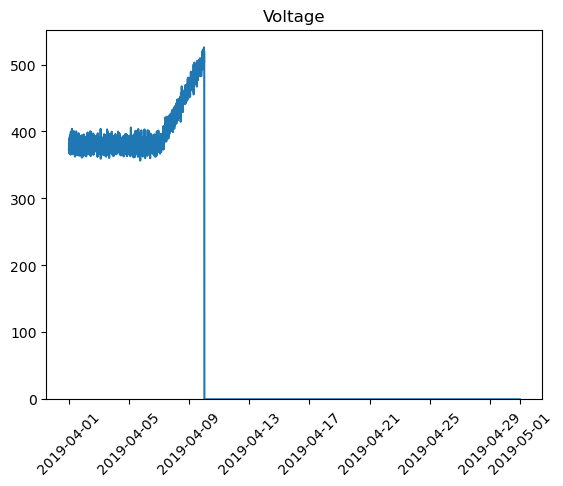

In [247]:
f, ax = plt.subplots(1)
ax.plot(df_volt['timestamp'], df_volt['voltage (kV)'])
ax.set_ylim(ymin=0)
plt.title('Voltage')
plt.xticks(rotation=45)
plt.show(f)

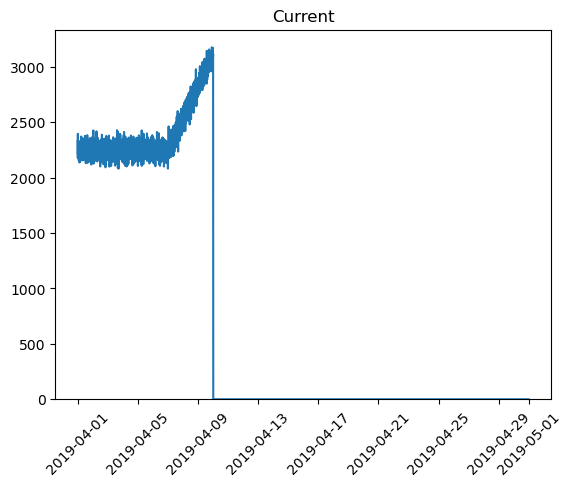

In [248]:
f, ax = plt.subplots(1)
ax.plot(df_volt['timestamp'], df_volt['current (A)'])
ax.set_ylim(ymin=0)
plt.title('Current')
plt.xticks(rotation=45)
plt.show(f)

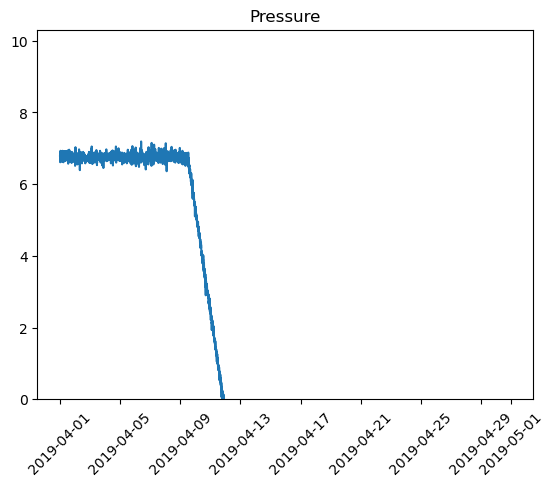

In [283]:
f, ax = plt.subplots(1)
ax.plot(df_gas['timestamp'], df_gas['density (lb/ft3)'])
ax.set_ylim(ymin=0)
plt.title('Pressure')
plt.xticks(rotation=45)
plt.show(f)

In [8]:
# save data to csv file
filename = f'{name}-data-{calendar.month_name[month].lower()}-{year}.csv'
#df.to_csv(filename, index=False)